
**<h1><span style="color:red"><u>Fraud</u></span></h1>**
**Réalisé par : Toullec Nastassia, Marie Stéphanie et Abdelaziz Sayad**

### <span style="color:yellow"> 0. Importation des librairies</span> 

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency 
import warnings
from scipy.stats import pearsonr
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeCV, Ridge,ElasticNetCV, ElasticNet, Lasso, LassoCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import statsmodels.api
warnings.filterwarnings('ignore')
%matplotlib inline

## <span style="color:red"> I. Audit des données</span> 

Le jeu de données que nous allons utiliser, recense diverses caractéristiques d'utilisateurs et leur transactions.
Le but de notre audit est de predire si une transaction est fraudeuse.

Le dataset comporte <strong>11 colonnes</strong>, pour environ <strong>151113 lignes</strong>.
Les variables sont les suivantes :

- <strong>user_id</strong>	identifiant d'utilisateur
- <strong>signup_time</strong>	heure de connexion
- <strong>purchase_time</strong>	heure d'achat
- <strong>purchase_value</strong>	montant de la transaction
- <strong>device_id</strong>	identifiant du moyen de connexion
- <strong>source</strong>	moyen d'accés au site
- <strong>browser</strong>	navigateur utilisé
- <strong>sex</strong>	sexe
- <strong>age</strong>	age
- <strong>ip_adress</strong>	adresse IP de l'utilisateur
- <strong>is_fraud</strong>	variable cible: identifiant de la fraud

Le jeu de données qui nous intéresse ici contient dix variables explicatives.
La variable expliquée est <strong>is_fraud</strong> soit 0 non frauduleux et des 1 pour frauduleux . 
La problématique est la clasification avec apprentissage supervisé.

### <span style="color:blue"> **A. Exploration un jeu de données**</span> 

<span style="color:green"> **1. Chargement des données**</span> 

Nous chargeons les données et affichons les premières lignes.

In [2]:
df = pd.read_csv(filepath_or_buffer = 'fraud.csv',
                           sep = ',',
                           header = 0)
df.head(10)                    

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,is_fraud
0,22058,2015-02-24 22:55:49,2015-04-18 2:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 1:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 7:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0
5,159135,2015-05-21 6:03:03,2015-07-09 8:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0
6,50116,2015-08-01 22:40:52,2015-08-27 3:37:57,11,IWKVZHJOCLPUR,Ads,Chrome,F,19,3.987484e+09,0
7,360585,2015-04-06 7:35:45,2015-05-25 17:21:14,27,HPUCUYLMJBYFW,Ads,Opera,M,34,1.692459e+09,0
8,159045,2015-04-21 23:38:34,2015-06-02 14:01:54,30,ILXYDOZIHOOHT,SEO,IE,F,43,3.719094e+09,0
9,182338,2015-01-25 17:49:49,2015-03-23 23:05:42,62,NRFFPPHZYFUVC,Ads,IE,M,31,3.416747e+08,0


<span style="color:green"> **2. Nettoyage du jeu de données**</span> 

<strong>Nous recréons les variables temporelles pour analyser la temporalité des données.</strong>

1/ Les variables signup_time et purchase_time, sont divisées chacune par date et heure, nous permettant de créer 4 variables supplémentaires :
<ul>
    <li>signup_day</li>
    <li>signup_time</li>
    <li>purchase_day</li>
    <li>purshase_time</li>
</ul>

In [3]:
#Les variables signup_time et purchase_time se composent des dates avec les heures, 
#pour mieux visualiser ces donnés on va les séparer
df['signup_day'] = df['signup_time'].apply(lambda time: time.split( )[0])
df['signup_time'] = df['signup_time'].apply(lambda time: time.split( )[1])
df['purchase_day'] = df['purchase_time'].apply(lambda time: time.split( )[0])
df['purchase_time'] = df['purchase_time'].apply(lambda time: time.split( )[1]) 

df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,is_fraud,signup_day,purchase_day
0,22058,22:55:49,2:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,2015-02-24,2015-04-18
1,333320,20:39:50,1:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,2015-06-07,2015-06-08
2,1359,18:52:44,18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,2015-01-01,2015-01-01
3,150084,21:13:25,13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,2015-04-28,2015-05-04
4,221365,7:09:52,18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,2015-07-21,2015-09-09


2/ puis nous divisons chacune des variables signup_day et purchase_day en 3 variables distinctes.
Ainsi la date de connexion se compose de :
<ul>
    <li>signup_day</li>
    <li>signup_month</li>
    <li>signup_year</li>
</ul> 

Pour la date d'achat : 

<ul>
    <li>purchase_day</li>
    <li>purchase_month</li>
    <li>purchase_year</li>
</ul> 

Cette ventilation nous permettra d'analyser et détecter les tendances des transactions dans le temps.

In [4]:
df['signup_year'] = df['signup_day'].apply(lambda date: date.split('-')[0])
df['signup_month'] = df['signup_day'].apply(lambda date: date.split('-')[1])
df['signup_day'] = df['signup_day'].apply(lambda date: date.split('-')[2])


df['purchase_year'] = df['purchase_day'].apply(lambda date: date.split('-')[0])
df['purchase_month'] = df['purchase_day'].apply(lambda date: date.split('-')[1])
df['purchase_day'] = df['purchase_day'].apply(lambda date: date.split('-')[2])

df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,is_fraud,signup_day,purchase_day,signup_year,signup_month,purchase_year,purchase_month
0,22058,22:55:49,2:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,24,18,2015,02,2015,04
1,333320,20:39:50,1:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,07,08,2015,06,2015,06
2,1359,18:52:44,18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,01,01,2015,01,2015,01
3,150084,21:13:25,13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,28,04,2015,04,2015,05
4,221365,7:09:52,18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,21,09,2015,07,2015,09


Nous mettons les variables dans l'ordre pour une meilleure lecture.

In [5]:
df = df[['user_id','signup_time','signup_day', 'signup_month', 'signup_year',
        'purchase_time','purchase_day', 'purchase_month', 'purchase_year','purchase_value',
        'device_id','source','browser','sex', 'age','ip_address','is_fraud']]


df.head()

,user_id,signup_time,signup_day,signup_month,signup_year,purchase_time,purchase_day,purchase_month,purchase_year,purchase_value,device_id,source,browser,sex,age,ip_address,is_fraud
0,22058,22:55:49,24,02,2015,2:47:11,18,04,2015,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,20:39:50,07,06,2015,1:38:54,08,06,2015,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,18:52:44,01,01,2015,18:52:45,01,01,2015,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,21:13:25,28,04,2015,13:54:50,04,05,2015,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,7:09:52,21,07,2015,18:40:53,09,09,2015,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


<strong>Nous vérifions les valeurs éventuellement manquantes.</strong>

In [ ]:
df.isna().sum() #affichez les valeurs manquantes
#Il n'y a pas de valeurs manquantes

Le jeu de données de contient pas de valeurs manquantes

<strong>Nous vérifions les doublons</strong>

In [ ]:
print('Lignes de transactions dupliquées:',df.duplicated().sum())

print('Doublons sur les user id:',df['user_id'].duplicated().sum())
print('Doublons sur les adresse ip:' ,df['ip_address'].duplicated().sum())
print('Doublons sur les device id:',df['device_id'].duplicated().sum())

Il n y a pas de globalement de doublons sur les lignes de transactions, nous noterons l'existence de doublons sur les adresses ip et les devices id, malgré l'absence de doublons sur les user id. Nous pourrons analyser ces données ultérieurement.

<span style="color:green"> **3. Analyse descriptive des données**</span> 

Le jeu de données se compose ainsi : 

In [43]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   signup_day      151112 non-null  object 
 3   signup_month    151112 non-null  object 
 4   signup_year     151112 non-null  object 
 5   purchase_time   151112 non-null  object 
 6   purchase_day    151112 non-null  object 
 7   purchase_month  151112 non-null  object 
 8   purchase_year   151112 non-null  object 
 9   purchase_value  151112 non-null  int64  
 10  device_id       151112 non-null  object 
 11  source          151112 non-null  object 
 12  browser         151112 non-null  object 
 13  sex             151112 non-null  object 
 14  age             151112 non-null  int64  
 15  ip_address      151112 non-null  float64
 16  is_fraud        151112 non-null  int64  
dtypes: float64

<strong>Analyse descriptives des variables quantitatives</strong>

Les données numériques sont globalement distribuées de la façon suivantes : 

In [44]:
df.describe() #la distribution des données

,user_id,purchase_value,age,ip_address,is_fraud
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


Pour une analyse plus poussée, nous nous pencherons sur l'analyse descriptives des variables quantitatives <strong>age</strong> et <strong>purchase_value</strong>. Les variables user_id, ip_adresse étant des identifiants et is_fraud une variable binaire, n'entrent pas pour l'instant dans le scope d'analyse.

In [45]:
print(df.duplicated().sum())

num_data = df[['purchase_value','age']]

stats = pd.DataFrame(num_data.median(), columns = ['mediane'])
stats['moyenne'] = num_data.mean()

stats['moyenne - ecart type'] = pd.DataFrame(num_data.mean() - num_data.std())

stats['moyenne + ecart type'] = pd.DataFrame(num_data.mean() +  num_data.std())


stats.round(2)

0


,mediane,moyenne,moyenne - ecart type,moyenne + ecart type
purchase_value,35.0,36.94,18.61,55.26
age,33.0,33.14,24.52,41.76


<Figure size 504x504 with 0 Axes>

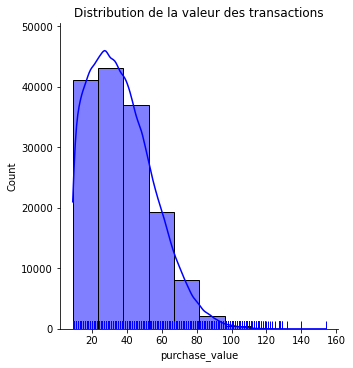

In [46]:
fig = plt.figure(figsize=(7,7));
sns.displot(df['purchase_value'], bins=10, kde=True, rug=True, color='blue').set(title="Distribution de la valeur des transactions");

Tout comme le confirme les médiane/moyenne, nous constatons dans la distribution graphique que la valeur des transactions sont d'environ 30-40 €.

<Figure size 504x504 with 0 Axes>

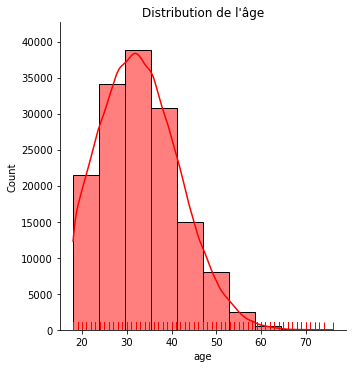

In [47]:
fig = plt.figure(figsize=(7,7));
sns.displot(df['age'], bins=10, kde=True, rug=True, color='red').set(title="Distribution de l'âge");

Pareil pour l'âge, il y a plus d'individus agés de 30-35 ans environ.

Statistiques valeurs d''achats avec/sans fraude: 

In [48]:
#Une mesure de la dispersion des valeurs
ecart_type_pv = num_data['purchase_value'].std()
ecart_type_a = num_data['age'].std()

print(ecart_type_pv, ecart_type_a)

18.322762148660615 8.617733490959177


Statistiques valeurs d'achats avec/sans fraude: 

In [49]:
purchase_value_by_fraud = df.groupby(['is_fraud']).agg({'purchase_value':['sum','mean','median','min','max']})

purchase_value_by_fraud

purchase_value                           
                    sum       mean median min  max
is_fraud                                          
0               5057890  36.929418   35.0   9  154
1                523488  36.993004   35.0   9  111

Statistiques sur l''âge des individus  avec/sans fraude:

In [50]:
age_by_fraud = df.groupby(['is_fraud']).agg({'age':['mean','median','min','max']})
age_by_fraud

age               
               mean median min max
is_fraud                          
0         33.122356   33.0  18  76
1         33.318281   33.0  18  68

La moyenne et la médiane des variables age et purchase_value sont très proches, les valeurs sont plutôt homogènes.

Pour analyser la dispersion des valeurs, nous avons déterminer l'intervalle (moyenne -/+ ecart type) dans lequel les valeurs sont au plus proche de la moyenne.

Nous allons par ailleurs déterminer la proportions de valeurs présentes ou non dans cet intervalle.

In [51]:

num_data['purchase_value_in'] = num_data['purchase_value'].between(stats['moyenne - ecart type'][0], stats['moyenne + ecart type'][0]).astype(int)
print('Dispersion des achats\n',num_data['purchase_value_in'].value_counts(normalize=True))

outliers_purchase_value = num_data[num_data.purchase_value_in==0]

print('Achat moyen et médian en dehos de l\'intervalle:',outliers_purchase_value['purchase_value'].mean(), outliers_purchase_value['purchase_value'].median())

num_data['age_in'] = num_data['age'].between(stats['moyenne - ecart type'][1], stats['moyenne + ecart type'][1]).astype(int)

print('Dispersion des âges \n',num_data['age_in'].value_counts(normalize=True))
      
outliers_age = num_data[num_data.age_in==0]

print('age moyen et median en dehors de l\'intervalle :', outliers_age['age'].mean(), outliers_age['age'].median())


Dispersion des achats
 1    0.664414
0    0.335586
Name: purchase_value_in, dtype: float64
Achat moyen et médian en dehos de l'intervalle: 39.93602965825955 18.0
Dispersion des âges 
 1    0.653826
0    0.346174
Name: age_in, dtype: float64
age moyen et median en dehors de l'intervalle : 33.967406472825985 24.0


Nous constatons que près de 33-34 % des achats et d'individus selon leur age sont dispersés dans le jeu de données

Les achats moyens des valeurs extrêmes sont plus elevées que la moyenne globale contrairement à la mediane des valeurs extrêmes qui est plus basse que la médiane globale.

<strong>Relation entre les variables quantitatives et la variable is_fraud</strong>

In [52]:
#Une dernière étape consiste à étudier les relations entre variables quantitatives et qualitatives.

df[['purchase_value','age']].corr()

,purchase_value,age
purchase_value,1.00000,0.00237
age,0.00237,1.00000


In [53]:
cof,pvalue = pearsonr(df['purchase_value'], df['age'])

print(pd.DataFrame(pearsonr(df['purchase_value'], df['age']), index=['pearson_coeff','p-value'], columns=['purchase_']))


               purchase_
pearson_coeff   0.002370
p-value         0.356938


la p-value est > 5%, le coefficient est proche de null, il n y a pas de corrélation entre les variables age et purchase_value.
Ces variables sont indépendantes.

In [54]:
result = statsmodels.formula.api.ols('age ~ is_fraud', data=df).fit()
table = statsmodels.api.stats.anova_lm(result)

table


,df,sum_sq,mean_sq,F,PR(>F)
is_fraud,1.0,4.923416e+02,492.341625,6.629742,0.01003
Residual,151110.0,1.122182e+07,74.262564,NaN,NaN


La p-value (PR(>F)) est inférieur à 5% donc on rejette l'hypothèse selon laquelle is_fraud n'influe pas sur l'age.

          age_groups        is_fraud  user_id
0   (17.942, 27.667]  non frauduleux    39200
1   (17.942, 27.667]      frauduleux     3787
2   (27.667, 37.333]  non frauduleux    57025
3   (27.667, 37.333]      frauduleux     6117
4     (37.333, 47.0]  non frauduleux    32597
5     (37.333, 47.0]      frauduleux     3388
6     (47.0, 56.667]  non frauduleux     7232
7     (47.0, 56.667]      frauduleux      761
8   (56.667, 66.333]  non frauduleux      880
9   (56.667, 66.333]      frauduleux       97
10    (66.333, 76.0]  non frauduleux       27
11    (66.333, 76.0]      frauduleux        1


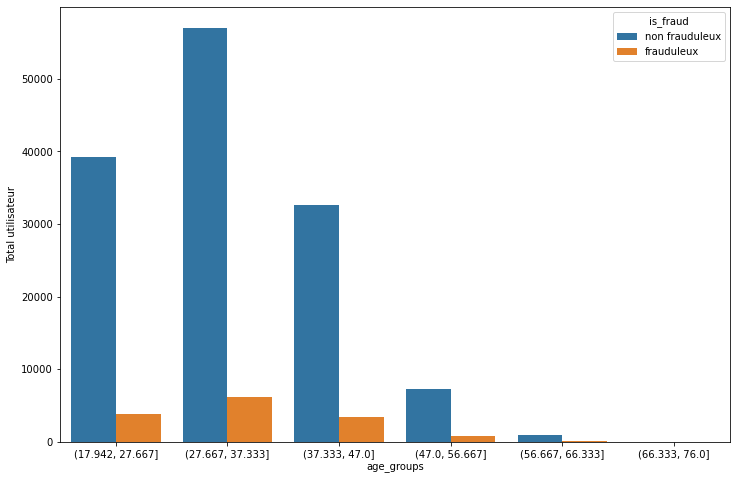

In [55]:
df_age =df.select_dtypes(include=['int64'])


df_age['age_groups'] = pd.cut(df_age['age'], bins = 6)



df_age = df_age.groupby(['age_groups','is_fraud']).agg({'user_id':'count'}).reset_index()

#df_age.replace(to_replace= [{'0': 'non frauduleux','1': 'frauduleux'}])

df_age['is_fraud'] = df_age['is_fraud'].apply(lambda x: 'frauduleux' if x==1 else 'non frauduleux')

print(df_age)

plt.figure(figsize = (12,8))
sns.barplot(data = df_age, x = 'age_groups', y = 'user_id', hue = 'is_fraud')

plt.ylabel('Total utilisateur');
plt.show();



Les fraudes proviennent principalement des transactions dont les individus sont agés de 27-37 ans.

In [56]:
result = statsmodels.formula.api.ols('purchase_value ~ is_fraud', data=df).fit()
table = statsmodels.api.stats.anova_lm(result)

table

,df,sum_sq,mean_sq,F,PR(>F)
is_fraud,1.0,5.185735e+01,51.857354,0.154464,0.694306
Residual,151110.0,5.073148e+07,335.725491,NaN,NaN


la p-value (PR(>F)) est supérieur à 5% donc l'hypothèse selon laquelle is_fraud n'influe pas sur purchase_value est confirmée.

<strong>Analyse descriptives des variables qualitatives</strong>

On détermine les variables catégorielles et on les stocke dans un tableau cat_data:

In [57]:
cat_data  = df.select_dtypes(include = 'O')
cat_data['user_id'] = df['user_id']
cat_data['ip_address'] = df['ip_address']
cat_data['is_fraud'] = df['is_fraud']

cat_data

,signup_time,signup_day,signup_month,signup_year,purchase_time,purchase_day,purchase_month,purchase_year,device_id,source,browser,sex,user_id,ip_address,is_fraud
0,22:55:49,24,02,2015,2:47:11,18,04,2015,QVPSPJUOCKZAR,SEO,Chrome,M,22058,7.327584e+08,0
1,20:39:50,07,06,2015,1:38:54,08,06,2015,EOGFQPIZPYXFZ,Ads,Chrome,F,333320,3.503114e+08,0
2,18:52:44,01,01,2015,18:52:45,01,01,2015,YSSKYOSJHPPLJ,SEO,Opera,M,1359,2.621474e+09,1
3,21:13:25,28,04,2015,13:54:50,04,05,2015,ATGTXKYKUDUQN,SEO,Safari,M,150084,3.840542e+09,0
4,7:09:52,21,07,2015,18:40:53,09,09,2015,NAUITBZFJKHWW,Ads,Safari,M,221365,4.155831e+08,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151107,3:03:34,27,01,2015,0:30:47,29,03,2015,XPSKTWGPWINLR,SEO,Chrome,M,345170,3.451155e+09,1
151108,17:43:29,15,05,2015,12:24:39,26,05,2015,LYSFABUCPCGBA,SEO,Safari,M,274471,2.439047e+09,0
151109,23:07:31,03,03,2015,7:07:47,20,05,2015,MEQHCSJUBRBFE,SEO,IE,F,368416,2.748471e+09,0
151110,20:06:07,09,07,2015,9:34:46,07,09,2015,CMCXFGRHYSTVJ,SEO,Chrome,M,207709,3.601175e+09,0


On regarde les modalités les plus fréquentes des variables qualitatives et comment se répartissent-elles:

In [58]:
print(cat_data['is_fraud'].value_counts())
print('\n')
print(cat_data['is_fraud'].value_counts(normalize=True))
#9,3 % transactions sont fraudeause

0    136961
1     14151
Name: is_fraud, dtype: int64


0    0.906354
1    0.093646
Name: is_fraud, dtype: float64


In [59]:
print(cat_data['device_id'].value_counts().head())
print('\n')
print(cat_data['device_id'].mode())#Nous avons 6 id qui ont fait max d'achats = 20 chacun

CQTUVBYIWWWBC    20
ITUMJCKWEYNDD    20
EQYVNEGOFLAWK    20
ZUSVMDEZRBDTX    20
NGQCKIADMZORL    20
Name: device_id, dtype: int64


0    CQTUVBYIWWWBC
1    EQYVNEGOFLAWK
2    ITUMJCKWEYNDD
3    KIPFSCNUGOLDP
4    NGQCKIADMZORL
5    ZUSVMDEZRBDTX
dtype: object


In [60]:
print(cat_data['ip_address'].value_counts().head())
print('\n')
print(cat_data['ip_address'].mode())#4 ip_address qui ont fait max d'achats = 20 chacun

3.874758e+09    20
2.050964e+09    20
5.760609e+08    20
1.502818e+09    20
1.797069e+09    19
Name: ip_address, dtype: int64


0    5.760609e+08
1    1.502818e+09
2    2.050964e+09
3    3.874758e+09
dtype: float64


In [61]:
print(cat_data['source'].value_counts(normalize=True))
print('\n')
print(cat_data['source'].mode())#On récupére la modalité la plus fréquente: SEO

SEO       0.401126
Ads       0.396269
Direct    0.202605
Name: source, dtype: float64


0    SEO
dtype: object


In [62]:
print(cat_data['browser'].value_counts(normalize=True))
print('\n')
print(cat_data['browser'].mode())#On récupére la modalité la plus fréquente: Chrome

Chrome     0.406533
IE         0.243045
Safari     0.163237
FireFox    0.162859
Opera      0.024326
Name: browser, dtype: float64


0    Chrome
dtype: object


In [63]:
print(cat_data['sex'].value_counts(normalize=True))
print('\n')
print(cat_data['sex'].mode())#On récupére la modalité la plus fréquente :homme

M    0.584288
F    0.415712
Name: sex, dtype: float64


0    M
dtype: object


In [64]:
print(cat_data['signup_day'].value_counts(normalize=True))
print('\n')
print(cat_data['signup_day'].mode())#On récupére la modalité la plus fréquente :day 07

07    0.038905
02    0.038025
12    0.037985
08    0.037707
01    0.037370
10    0.037237
06    0.037151
11    0.037151
03    0.036767
05    0.036655
04    0.036628
09    0.036311
13    0.033889
17    0.033816
14    0.033108
16    0.033075
15    0.032810
18    0.029773
25    0.029342
19    0.029323
23    0.029104
21    0.029012
27    0.028899
24    0.028754
26    0.028701
20    0.028628
22    0.028608
28    0.028581
29    0.024935
30    0.024697
31    0.017054
Name: signup_day, dtype: float64


0    07
dtype: object


In [65]:
print(cat_data['purchase_day'].value_counts(normalize=True))
print('\n')
print(cat_data['purchase_day'].mode())#On récupére la modalité la plus fréquente :day 07

07    0.035987
11    0.035861
06    0.035854
04    0.035417
08    0.035384
02    0.035331
12    0.035245
05    0.034895
10    0.034881
09    0.034696
03    0.034597
01    0.034577
13    0.032248
20    0.032175
26    0.031970
19    0.031798
28    0.031685
18    0.031678
22    0.031533
23    0.031394
15    0.031387
21    0.031281
17    0.031215
27    0.031215
14    0.031209
25    0.030865
16    0.030772
24    0.030381
29    0.029071
30    0.028131
31    0.017265
Name: purchase_day, dtype: float64


0    07
dtype: object


On affiche des histogrammes pour mieux comprendre la distribution des données. Pour bien voir les résultats on les separe en 3 parties.

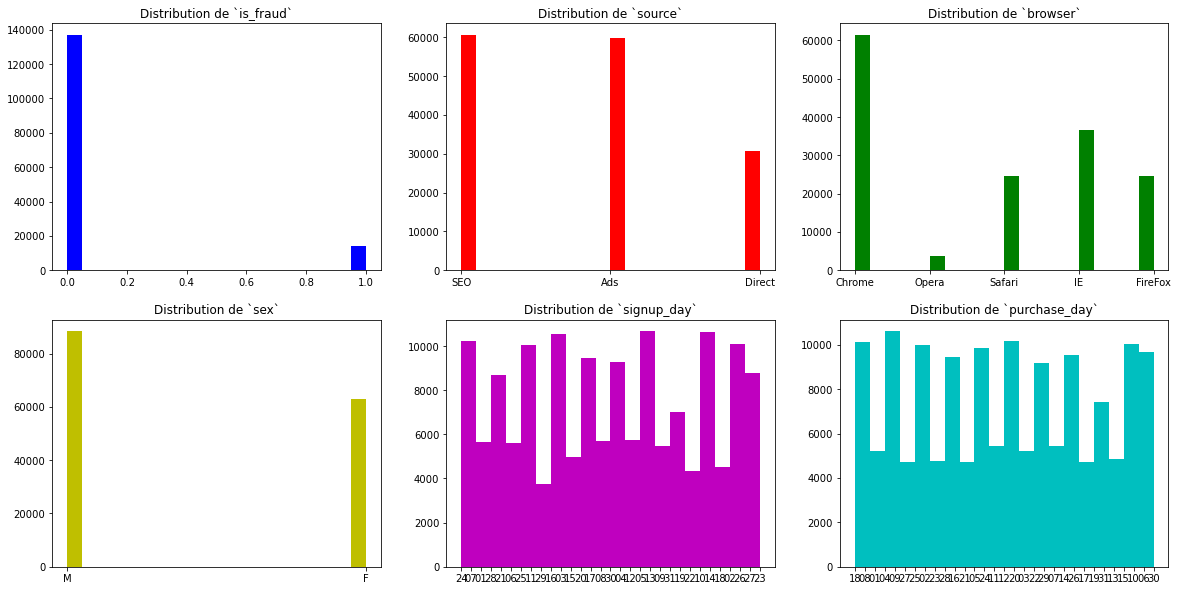

In [66]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

axes[0][0].hist(df['is_fraud'], color='b', bins=20)
axes[0][0].set_title('Distribution de `is_fraud`')
axes[0][1].hist(df['source'], color='r', bins=20)
axes[0][1].set_title('Distribution de `source`')
axes[0][2].hist(df['browser'], color='g', bins=20)
axes[0][2].set_title('Distribution de `browser`')

axes[1][0].hist(df['sex'], color='y', bins=20)
axes[1][0].set_title('Distribution de `sex`')
axes[1][1].hist(df['signup_day'], color='m', bins=20)
axes[1][1].set_title('Distribution de `signup_day`')
axes[1][2].hist(df['purchase_day'], color='c', bins=20)
axes[1][2].set_title('Distribution de `purchase_day`')

plt.show()

In [67]:
max_fraud_id = df.groupby('is_fraud').device_id.value_counts()[1, :]#combien frauds par ID
print(max_fraud_id)

#On les affiche pour mieux voir la distribution
plt.hist(max_fraud_id, color='b', bins=20)
plt.ylabel('Amount_of_id')
plt.xlabel('Numbers_of_fraud');

TypeError: (1, slice(None, None, None))

Pour mieux visualiser, on affiche à partir de 3 frauds:

In [ ]:
max_fraud_id_more3 = []
for i in max_fraud_id:
    if i >= 3:
        max_fraud_id_more3.append(i)

plt.hist(max_fraud_id_more3, color='b', bins=20)
plt.ylabel('Amount_of_id')
plt.xlabel('Numbers_of_fraud');

In [ ]:
max_fraud_ip = df.groupby('is_fraud').ip_address.value_counts()[1, :]#combien frauds par ip_address
print(max_fraud_ip)

#On les affiche pour mieux voir la distribution
plt.hist(max_fraud_ip, color='b', bins=20)
plt.ylabel('Amount_of_ip')
plt.xlabel('Numbers_of_fraud');

In [ ]:
#Pour mieux visualiser, on affiche à partir de 3 frauds
max_fraud_ip_more3 = []
for i in max_fraud_ip:
    if i >= 3:
        max_fraud_ip_more3.append(i)

plt.hist(max_fraud_ip_more3, color='b', bins=20)
plt.ylabel('Amount_of_ip')
plt.xlabel('Numbers_of_fraud');

Pour nos variables qualitatives on va utiliser la table de contingence. On appelle une table de contingence, la table croisée contenant les différentes catégories des deux variables en question. Pour afficher une table de contingence, on utilise la fonction crosstab avec les deux variables en argument. Cette table de contingence permet de visualiser comment se distribuent les catégories de la variable 1 au sein de la variable 2. Pour des variables totalement indépendantes, la distribution doit être proportionnelle entre chaque ligne et entre chaque colonne.

In [68]:
print(pd.crosstab(df['device_id'],df['is_fraud']))
print('\n')
print(pd.crosstab(df['ip_address'],df['is_fraud']))
print('\n')

print(pd.crosstab(df['source'],df['is_fraud']))
print('\n')
print(pd.crosstab(df['browser'],df['is_fraud']))
print('\n')
print(pd.crosstab(df['sex'],df['is_fraud']))
print('\n')
print(pd.crosstab(df['signup_day'],df['is_fraud']))
print('\n')
print(pd.crosstab(df['purchase_day'],df['is_fraud']))


is_fraud       0   1
device_id           
AAALBGNHHVMKG  1   0
AAAWIHVCQELTP  1   0
AAAXJHWCLISKY  1   0
AAAXXOZJRZRAO  1  10
AABFGRPBQHWFQ  1   0
...           ..  ..
ZZZGSIJRNCXBJ  1   0
ZZZIKLJSVSQMF  1   0
ZZZKJIZHJEDFN  1   0
ZZZMVOGBAJVTM  1   0
ZZZXASJUVUNMV  1   0

[137956 rows x 2 columns]


is_fraud      0  1
ip_address        
5.209350e+04  1  0
9.344714e+04  1  0
1.058185e+05  1  0
1.175667e+05  1  0
1.314238e+05  1  0
...          .. ..
4.294674e+09  1  0
4.294715e+09  1  0
4.294720e+09  1  0
4.294822e+09  1  0
4.294850e+09  1  0

[143511 rows x 2 columns]


is_fraud      0     1
source               
Ads       54368  5513
Direct    27390  3226
SEO       55203  5412


is_fraud      0     1
browser              
Chrome    55363  6069
FireFox   22268  2342
IE        33540  3187
Opera      3348   328
Safari    22442  2225


is_fraud      0     1
sex                  
F         57102  5717
M         79859  8434


is_fraud       0    1
signup_day           
01          4841  80

Le test qu'on effectue alors est un test du  χ2  par table de contingence.
Pour chaque case d'un tableau, il effectue un test du  χ2 (test de proportions) entre l'effectif de la case et l'effectif total de la colonne.
La statistique de test est alors obtenue en faisant la somme de toutes ces statistiques.

Pour ce test, on pose comme les hypothèses nulles :
1."les variables device_id et is_fraud sont indépendantes" 
2."les variables ip_address et is_fraud sont indépendantes"
3."les variables source et state is_fraud indépendantes" 
4."les variables browser et state is_fraud indépendantes" 
5."les variables sex et state is_fraud indépendantes" 
6."les variables signup_day et is_fraud sont indépendantes"
7."les variables purchase_day et is_fraud sont indépendantes" 

Ce test peut s'effectuer tout simplement grâce à la fonction chi2_contingency de scipy appliquée à la table de contingence.
Elle renvoie un array de 4 éléments : la statistique du test, la p-value, le degré de liberté et la liste des fréquences attendues. Pour rejeter l'hypothèse nulle, il est nécessaire que la p-value soit inférieure à 5%.

In [69]:
#L'hypothèse nulle №1
table1=pd.crosstab(df['device_id'],df['is_fraud'])
resultats_test = chi2_contingency(table1)
statistique = resultats_test[0]
p_valeur = resultats_test[1]
degre_liberte = resultats_test[2]

print(statistique.round(1), p_valeur,degre_liberte)

# p-value < 5% donc on rejette H0

131422.8 1.0 137955


In [70]:
#L'hypothèse nulle №2
table2=pd.crosstab(df['ip_address'],df['is_fraud'])
resultats_test = chi2_contingency(table2)
statistique = resultats_test[0]
p_valeur = resultats_test[1]
degre_liberte = resultats_test[2]

print(statistique.round(1), p_valeur,degre_liberte)

# p-value < 5% donc on rejette H0

143413.2 0.5712286437051614 143510


In [71]:
#L'hypothèse nulle №3
table3=pd.crosstab(df['source'],df['is_fraud'])
resultats_test = chi2_contingency(table3)
statistique = resultats_test[0]
p_valeur = resultats_test[1]
degre_liberte = resultats_test[2]

print(statistique.round(1), p_valeur,degre_liberte)

# p-value > 5% donc on accepte H0

64.9 7.981990836440143e-15 2


In [ ]:
#L'hypothèse nulle №4
table4=pd.crosstab(df['browser'],df['is_fraud'])
resultats_test = chi2_contingency(table4)
statistique = resultats_test[0]
p_valeur = resultats_test[1]
degre_liberte = resultats_test[2]

print(statistique.round(1), p_valeur,degre_liberte)

# p-value presque 5% donc on rejette H0

In [72]:
#L'hypothèse nulle №5
table5=pd.crosstab(df['sex'],df['is_fraud'])
resultats_test = chi2_contingency(table5)
statistique = resultats_test[0]
p_valeur = resultats_test[1]
degre_liberte = resultats_test[2]

print(statistique.round(1), p_valeur,degre_liberte)

# p-value < 5% donc on rejette H0

8.8 0.003072654263243465 1


In [ ]:
#L'hypothèse nulle №6
table6=pd.crosstab(df['signup_day'],df['is_fraud'])
resultats_test = chi2_contingency(table6)
statistique = resultats_test[0]
p_valeur = resultats_test[1]
degre_liberte = resultats_test[2]

print(statistique.round(1), p_valeur,degre_liberte)

# p-value < 5% donc on rejette H0

In [73]:
#L'hypothèse nulle №7
table7=pd.crosstab(df['purchase_day'],df['is_fraud'])
resultats_test = chi2_contingency(table7)
statistique = resultats_test[0]
p_valeur = resultats_test[1]
degre_liberte = resultats_test[2]

print(statistique.round(1), p_valeur,degre_liberte)

# p-value < 5% donc on rejette H0

5446.1 0.0 30


Comme pour les variables quantitatives, on peut mesurer le niveau de corrélation entre deux variables qualitatives. Pour cela, on utilise le V de Cramer corrigé pour contrer le biais qui utilise les résultats du test du  χ2. Il renvoie une valeur entre 0 et 1.

In [74]:
def V_Cramer(table1, N):
    stat_chi2 = chi2_contingency(table1)[0]
    k = table1.shape[0]
    r = table1.shape[1]
    phi = max(0,(stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1,r_corr - 1))

V_Cramer(table1, df.shape[0])
#Le V_Cramer est 0.Il n'y a pas une corrélation entre device_id et is_fraud.

0.0

In [75]:
def V_Cramer(table2, N):
    stat_chi2 = chi2_contingency(table2)[0]
    k = table2.shape[0]
    r = table2.shape[1]
    phi = max(0,(stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1,r_corr - 1))

V_Cramer(table2, df.shape[0])
#Le V_Cramer est 0.Il n'y a pas une corrélation entre ip_address et is_fraud.

0.0

In [76]:
def V_Cramer(table3, N):
    stat_chi2 = chi2_contingency(table3)[0]
    k = table3.shape[0]
    r = table3.shape[1]
    phi = max(0,(stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1,r_corr - 1))

V_Cramer(table3, df.shape[0])
#Le V_Cramer n'est pas très élevé.
#On en déduit qu'il n'y a pas une forte corrélation entre source et is_fraud.

0.020405969624040766

In [ ]:
def V_Cramer(table4, N):
    stat_chi2 = chi2_contingency(table4)[0]
    k = table4.shape[0]
    r = table4.shape[1]
    phi = max(0,(stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1,r_corr - 1))

V_Cramer(table4, df.shape[0])
#Le V_Cramer n'est pas très élevé.
#On en déduit qu'il n'y a pas une forte corrélation entre browser et is_fraud.

In [79]:
def V_Cramer(table5, N):
    stat_chi2 = chi2_contingency(table5)[0]
    k = table5.shape[0]
    r = table5.shape[1]
    phi = max(0,(stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1,r_corr - 1))

V_Cramer(table5, df.shape[0])
#Le V_Cramer n'est pas très élevé.
#On en déduit qu'il n'y a pas une forte corrélation entre sex et is_fraud.

0.007167858133544223

In [80]:
def V_Cramer(table6, N):
    stat_chi2 = chi2_contingency(table6)[0]
    k = table6.shape[0]
    r = table6.shape[1]
    phi = max(0,(stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1,r_corr - 1))

V_Cramer(table6, df.shape[0])
#Le V_Cramer n'est pas très élevé.
#On en déduit qu'il n'y a pas une forte corrélation entre signup_day et is_fraud mais qu'elle n'est pas non plus négligeable.

NameError: name 'table6' is not defined

In [ ]:
def V_Cramer(table7, N):
    stat_chi2 = chi2_contingency(table7)[0]
    k = table7.shape[0]
    r = table7.shape[1]
    phi = max(0,(stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1,r_corr - 1))

V_Cramer(table7, df.shape[0])
#Le V_Cramer n'est pas très élevé.
#On en déduit qu'il n'y a pas une forte corrélation entre purchase_day et is_fraud mais qu'elle n'est pas non plus négligeable.

# Oversampling avec la normalisation

<span style="color:green"> **4. Feature Engineering / Model Evaluation**</span> 

La classification est utilisée dans le cadre d'une problématique d'apprentissage supervisé. Elle permet de modéliser une variable expliquée de type qualitatif, y, comme une fonction de la combinaison linéaire des variables explicatives, X.

Nous traiterons de la classification binaire : la variable expliquée est encodée de façon binaire et contient donc exactement deux catégories: 0 non frauduleux et des 1 pour frauduleux.

On parle de modèle de classification qui nous permet de prédire la classe d'appartenance de chacune des observations : en d'autres termes, à partir des variables explicatives du modèle, on prédit si une observation appartient à la classe négative ou positive.

Nous avons constaté qu'on a la présence des données déséquilibrées. Pour traiter ce probleme on va utiliser tout d'abord la method oversampling: SMOTE.

Le SMOTE, acronyme pour Synthetic Minority Oversampling TEchnique, est une méthode de suréchantillonnage des observations minoritaires. Pour éviter de réaliser un simple clonage des individus minoritaires, le SMOTE se base sur un principe simple : générer de nouveaux individus minoritaires qui ressemblent aux autres, sans être strictement identiques. Cela permet de densifier de façon plus homogène la population d’individus minoritaires.

C’est sur ces données transformées, auxquelles on a ajouté de faux individus synthétiques, que l’on va ensuite entraîner un modèle de Machine Learning.


In [6]:
#La preparation des donées.
#Nous avons decidé d'enlever les variables signup_time, purchase_time car ils impactent pas is_fraud.
#Le V_Cramer de device_id et ip_address sont à 0, ca veut dire que'il n'y a pas de corrélations avec is_fraud.
#On les enleve aussi.

df_n = df[['user_id','signup_day', 'signup_month', 'signup_year',
        'purchase_day', 'purchase_month', 'purchase_year','purchase_value',
        'source','browser','sex', 'age','is_fraud']]


df_n.head()

,user_id,signup_day,signup_month,signup_year,purchase_day,purchase_month,purchase_year,purchase_value,source,browser,sex,age,is_fraud
0,22058,24,02,2015,18,04,2015,34,SEO,Chrome,M,39,0
1,333320,07,06,2015,08,06,2015,16,Ads,Chrome,F,53,0
2,1359,01,01,2015,01,01,2015,15,SEO,Opera,M,53,1
3,150084,28,04,2015,04,05,2015,44,SEO,Safari,M,41,0
4,221365,21,07,2015,09,09,2015,39,Ads,Safari,M,45,0


Séparons le jeu de données en features / target. Assurons-nous d'avoir le bon format de données en entrée de nos futurs modèles.

In [7]:
#Definition X et y:
X = df_n.drop(['is_fraud'], axis = 1)
y = df_n.is_fraud

# split into 70:30 ration
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(105778, 12) (45334, 12) (105778,) (45334,)


On ajoute l'indexation des donées pour les traitées avec la precision par la suite.

In [8]:
### Indexation

X_train = X_train.set_index(i for i in range(105778))

X_test = X_test.set_index(i for i in range(45334))


Le SMOTE repose sur le calcul de distances euclidiennes entre les points. Il est donc influencé par l’échelle de vos variables. Pour que toutes les variables soient toutes traitées de la même manière, il est nécessaire de faire un scaling avant d’utiliser le SMOTE-->Les variables numériques doivent être normalisées.Tout d'habord on enleve les variables catégorielles.

In [9]:
# out of cat data
X_train_out=X_train.drop(['source', 'browser', 'sex'], axis = 1)
X_test_out=X_test.drop(['source', 'browser', 'sex'], axis = 1)
X_train_out.head()

,user_id,signup_day,signup_month,signup_year,purchase_day,purchase_month,purchase_year,purchase_value,age
0,95172,12,08,2015,30,08,2015,51,36
1,282369,23,02,2015,28,02,2015,11,32
2,51365,09,01,2015,09,01,2015,16,34
3,74074,01,05,2015,03,08,2015,40,32
4,294523,20,06,2015,10,08,2015,44,30


In [10]:
# Normalisation des données
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_out)
X_test_sc = scaler.fit_transform(X_test_out)

X_train_sc

array([[-0.90908609, -0.31135587,  1.70963461, ...,  0.        ,
         0.76590444,  0.32955645],
       [ 0.71354992,  0.9479972 , -0.9505524 , ...,  0.        ,
        -1.41592755, -0.13472583],
       [-1.28880807, -0.6548158 , -1.3939169 , ...,  0.        ,
        -1.14319855,  0.09741531],
       ...,
       [-0.1610493 ,  0.26107734,  1.26627011, ...,  0.        ,
         0.11135484, -1.64364324],
       [ 0.95956698, -0.88378909,  1.26627011, ...,  0.        ,
         0.65681284, -0.01865526],
       [ 0.46415231,  1.52043041, -0.5071879 , ...,  0.        ,
        -1.47047335, -0.59900811]])

Afin de s'assurer de bon deroulement de la normalisation, on affiche nos données comme un DataFrame.

In [11]:
X_train_pd = pd.DataFrame(X_train_sc, columns = ['user_id','signup_day','signup_month','signup_year', 'purchase_day','purchase_month',
                                      'purchase_year','purchase_value','age'])

X_test_pd = pd.DataFrame(X_test_sc, columns = ['user_id','signup_day','signup_month','signup_year', 'purchase_day','purchase_month',
                                      'purchase_year','purchase_value','age'])

X_train_pd.head()

,user_id,signup_day,signup_month,signup_year,purchase_day,purchase_month,purchase_year,purchase_value,age
0,-0.909086,-0.311356,1.709635,0.0,1.668218,0.749708,0.0,0.765904,0.329556
1,0.713550,0.947997,-0.950552,0.0,1.441418,-1.504488,0.0,-1.415928,-0.134726
2,-1.288808,-0.654816,-1.393917,0.0,-0.713179,-1.880187,0.0,-1.143199,0.097415
3,-1.091965,-1.570709,0.379541,0.0,-1.393579,0.749708,0.0,0.165901,-0.134726
4,0.818902,0.604537,0.822906,0.0,-0.599780,0.749708,0.0,0.384084,-0.366867


Maintenant on traite les variables catégorielles. StandardScaler modifier les variables binaires, c'est pour ca qu'on les a enlever aparavant.

In [12]:
#Encoder les variables catégoriels 
X2_train= pd.get_dummies(X_train[['source','browser','sex']])
X2_test= pd.get_dummies(X_test[['source','browser','sex']])
X2_train.head()

,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_F,sex_M
0,0,0,1,0,0,1,0,0,0,1
1,1,0,0,0,0,1,0,0,0,1
2,1,0,0,1,0,0,0,0,0,1
3,1,0,0,1,0,0,0,0,1,0
4,1,0,0,1,0,0,0,0,0,1


In [13]:
#On ajoute nos donées dans le meme tableau

X_train[['user_id','signup_day', 'signup_month', 'signup_year',
        'purchase_day', 'purchase_month', 'purchase_year','purchase_value',
        'age']]=X_train_pd[['user_id','signup_day', 'signup_month', 'signup_year',
        'purchase_day', 'purchase_month', 'purchase_year','purchase_value','age']]
X_train[['source_Ads','source_Direct','source_SEO','browser_Chrome','browser_FireFox','browser_IE','browser_Opera',
  'browser_Safari','sex_F','sex_M']]=X2_train[['source_Ads','source_Direct','source_SEO','browser_Chrome','browser_FireFox','browser_IE','browser_Opera',
  'browser_Safari','sex_F','sex_M']]

X_test[['user_id','signup_day', 'signup_month', 'signup_year',
        'purchase_day', 'purchase_month', 'purchase_year','purchase_value','age']]=X_test_pd[['user_id','signup_day', 'signup_month', 'signup_year',
        'purchase_day', 'purchase_month', 'purchase_year','purchase_value','age']]
X_test[['source_Ads','source_Direct','source_SEO','browser_Chrome','browser_FireFox','browser_IE','browser_Opera',
  'browser_Safari','sex_F','sex_M']]=X2_test[['source_Ads','source_Direct','source_SEO','browser_Chrome','browser_FireFox','browser_IE','browser_Opera',
  'browser_Safari','sex_F','sex_M']]


X_train.head()

,user_id,signup_day,signup_month,signup_year,purchase_day,purchase_month,purchase_year,purchase_value,source,browser,...,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_F,sex_M
0,-0.909086,-0.311356,1.709635,0.0,1.668218,0.749708,0.0,0.765904,SEO,IE,...,0,0,1,0,0,1,0,0,0,1
1,0.713550,0.947997,-0.950552,0.0,1.441418,-1.504488,0.0,-1.415928,Ads,IE,...,1,0,0,0,0,1,0,0,0,1
2,-1.288808,-0.654816,-1.393917,0.0,-0.713179,-1.880187,0.0,-1.143199,Ads,Chrome,...,1,0,0,1,0,0,0,0,0,1
3,-1.091965,-1.570709,0.379541,0.0,-1.393579,0.749708,0.0,0.165901,Ads,Chrome,...,1,0,0,1,0,0,0,0,1,0
4,0.818902,0.604537,0.822906,0.0,-0.599780,0.749708,0.0,0.384084,Ads,Chrome,...,1,0,0,1,0,0,0,0,0,1


In [14]:
#On enleve extra 'source', 'browser', 'sex'
X_train = X_train.drop(['source', 'browser', 'sex'], axis = 1)

X_test = X_test.drop(['source', 'browser', 'sex'], axis = 1)

X_train.head()

,user_id,signup_day,signup_month,signup_year,purchase_day,purchase_month,purchase_year,purchase_value,age,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_F,sex_M
0,-0.909086,-0.311356,1.709635,0.0,1.668218,0.749708,0.0,0.765904,0.329556,0,0,1,0,0,1,0,0,0,1
1,0.713550,0.947997,-0.950552,0.0,1.441418,-1.504488,0.0,-1.415928,-0.134726,1,0,0,0,0,1,0,0,0,1
2,-1.288808,-0.654816,-1.393917,0.0,-0.713179,-1.880187,0.0,-1.143199,0.097415,1,0,0,1,0,0,0,0,0,1
3,-1.091965,-1.570709,0.379541,0.0,-1.393579,0.749708,0.0,0.165901,-0.134726,1,0,0,1,0,0,0,0,1,0
4,0.818902,0.604537,0.822906,0.0,-0.599780,0.749708,0.0,0.384084,-0.366867,1,0,0,1,0,0,0,0,0,1


<strong>Oversampling</strong>

In [15]:
counter = Counter(y_train)
print('Before', counter)

Before Counter({0: 95844, 1: 9934})


In [16]:
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [17]:
counter = Counter(y_train)
print('After', counter)

After Counter({0: 95844, 1: 95844})


<span style="color:green"> **5. Modelisation**</span> 

In [20]:
def evaluate_model(y_test, y_pred):

    # Calcul de accuracy, precision, recall, f1-score, kappa score and balanced accuracy
    acc = metrics.accuracy_score(y_test, y_pred)
    prec = metrics.precision_score(y_test, y_pred)
    rec = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    b = metrics.balanced_accuracy_score(y_test,y_pred)
    
    return {'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'b': b }


<strong>                Logistic  Regression</strong>

In [21]:
# Instanciation d'un premier modèle

log = LogisticRegression()

# Entraînement 
log.fit(X_train, y_train)

# On prédit les y à partir de X_test<strong>Oversampling</strong>
pred = log.predict(X_test)

# Score du modèle
print(log.score(X_test, y_test))

#metrics du modele
log_eval =  evaluate_model(y_test, pred)
print('Accuracy:', log_eval['acc'])
print('Precision:', log_eval['prec'])
print('Recall:', log_eval['rec'])
print('F1 Score:', log_eval['f1'])
print("Balanced accuracy:",log_eval['b'])

# Matrice de confusion

pd.crosstab(y_test, pred,rownames=['Classe réelle'], colnames=['Classe prédite'])

0.7937971500419112
Accuracy: 0.7937971500419112
Precision: 0.25310364738716196
Recall: 0.6236661133507233
F1 Score: 0.3600766703176342
Balanced accuracy: 0.7174560350054928


Classe prédite,0,1
Classe réelle,,
0,33356,7761
1,1587,2630


Nous obtenons une accuracy proche des 80%, ce qui reflète donc pas trés excellentes performances pour notre modèle.

- Notre modèle classe 7785 transactions fraudulauses (faux positif) sur 1588 transactions non fraudulauses.
- Notre modèle classe 33332 transactions non fraudulauses (vrai négatif) sur 2629  transactions fraudulauses

In [26]:
# On affiche les coefficients obtenus

coeff=log.coef_

# On affiche la constante

intercept=log.intercept_

# On calcule les odd ratios

odd_ratios=np.exp(log.coef_)

# On crée un dataframe qui combine à la fois variables, coefficients et odd-ratios

resultats=pd.DataFrame(X_test.columns.tolist (), columns=["Variables"])

resultats['Coefficients']=log.coef_.tolist()[0]

resultats['Odd_Ratios']=np.exp(log.coef_).tolist()[0]

# On choisit d'afficher les variables avec l'odd ratio le plus élevé et le plus faible

resultats.loc[(resultats['Odd_Ratios']==max(resultats['Odd_Ratios']))|(resultats['Odd_Ratios']==min(resultats['Odd_Ratios']))]

,Variables,Coefficients,Odd_Ratios
2,signup_month,0.685918,1.985593
15,browser_Opera,-7.119710,0.000809


In [ ]:
print(resultats)

Interprétations:
Plus généralement, si l'odd ratio est supérieur à 1, cela signifie qu'une augmentation de la variable à laquelle est adossé le paramètre, augmente les chances d'appartenir à la classe fraud. S'il est égal à 1, la variable ne semble pas avoir d'impact sur la répartition entre les classes et finalement s'il est inférieur à 1, une augmentation de la valeur de la variable diminue les chances d'appartenir à la classe fraud.

On peut constater que purchase_year et signup_year ne semblent pas avoir d'impact sur la répartition entre les classes.
Signup_month augmente les chances d'appartenir à la classe fraud.Browser_Opera fait des operation "safe".
L'odd ratio est supérieur à 1: user_id, signup_month.

<strong>                Decision Tree</strong>

In [22]:
# Instanciation des modèles
tree = DecisionTreeClassifier()
# Entraînement 
tree.fit(X_train, y_train)

# Prédiction 
pred = tree.predict(X_test)

# Score du modèle
print(tree.score(X_test, y_test))

#metrics du modele
tree_eval =  evaluate_model(y_test, pred)
print('Accuracy:', tree_eval['acc'])
print('Precision:', tree_eval['prec'])
print('Recall:', tree_eval['rec'])
print('F1 Score:', tree_eval['f1'])
print("Balanced accuracy:",tree_eval['b'])

# Matrice de confusion

pd.crosstab(y_test, pred,rownames=['Classe réelle'], colnames=['Classe prédite'])

0.10513080689989852
Accuracy: 0.10513080689989852
Precision: 0.09356202061763456
Recall: 0.9921745316575765
F1 Score: 0.17099885564819353
Balanced accuracy: 0.5031646304225086


Classe prédite,0,1
Classe réelle,,
0,582,40535
1,33,4184


Nous obtenons une accuracy proche des 10%, ce qui reflète donc terribles performances pour notre modèle.

- Notre modèle classe 4188 transactions fraudulauses (faux positif) sur 29 transactions non fraudulauses.
- Notre modèle classe 535 transactions non fraudulauses (vrai négatif) sur 40582 transactions fraudulauses

<strong>               Algorithme des kNN : Algorithme des k plus proches voisins</strong>

In [23]:
# Instanciation des modèles
knc = KNeighborsClassifier()

# Entraînement 
knc.fit(X_train, y_train)

# Prédiction 
pred = knc.predict(X_test)

# Score du modèle
print(knc.score(X_test, y_test))

#metrics du modele
knc_eval =  evaluate_model(y_test, pred)
print('Accuracy:', knc_eval['acc'])
print('Precision:', knc_eval['prec'])
print('Recall:', knc_eval['rec'])
print('F1 Score:', knc_eval['f1'])
print("Balanced accuracy:",knc_eval['b'])

# Matrice de confusion

pd.crosstab(y_test, pred,rownames=['Classe réelle'], colnames=['Classe prédite'])

0.813010102792606
Accuracy: 0.813010102792606
Precision: 0.2758838383838384
Recall: 0.6217690301161963
F1 Score: 0.3821878871802347
Balanced accuracy: 0.7271965028003946


Classe prédite,0,1
Classe réelle,,
0,34235,6882
1,1595,2622


Nous obtenons une accuracy proche des 81%, ce qui est bien.

- Notre modèle classe 2615 transactions fraudulauses (faux positif) sur 1602 transactions non fraudulauses.
- Notre modèle classe 34135 transactions non fraudulauses (vrai négatif) sur 6982 transactions fraudulauses

<strong>             SVM : Séparateur à vastes marges</strong>

In [24]:
# Instanciation du modèle de régression RidgeCV
from sklearn.svm import LinearSVC
svm = LinearSVC(random_state=42)

# Entraînement 
svm.fit(X_train, y_train)

# Prédiction 
pred = svm.predict(X_test)

# Score du modèle
print(svm.score(X_test, y_test))

#metrics du modele
svm_eval =  evaluate_model(y_test, pred)
print('Accuracy:', svm_eval['acc'])
print('Precision:', svm_eval['prec'])
print('Recall:', svm_eval['rec'])
print('F1 Score:', svm_eval['f1'])
print("Balanced accuracy:",svm_eval['b'])

# Matrice de confusion

pd.crosstab(y_test, pred,rownames=['Classe réelle'], colnames=['Classe prédite'])


0.7979000308818988
Accuracy: 0.7979000308818988
Precision: 0.2574315706857647
Recall: 0.622243300924828
F1 Score: 0.3641915336571825
Balanced accuracy: 0.719079429483257


Classe prédite,0,1
Classe réelle,,
0,33548,7569
1,1593,2624


Nous obtenons une accuracy proche des 21%, ce qui est horrible.

- Notre modèle classe 3934 transactions fraudulauses (faux positif) sur 283 transactions non fraudulauses.
- Notre modèle classe 5963 transactions non fraudulauses (vrai négatif) sur 35154 transactions fraudulauses

Nous avons testé le modèle de machine learning SVC, celui-ci ne sera pas retenu car le temps de traitement (plus d'une heure) est beaucoup trop long.

Comparons les modèles : 

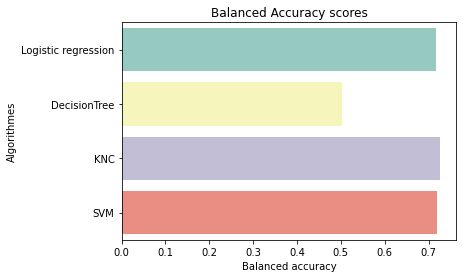

In [31]:

modeles_accuracy = [log_eval['b'], tree_eval['b'], knc_eval['b'], svm_eval['b']]
accuracy = pd.DataFrame({"Accuracy":modeles_accuracy,"Algorithmes":["Logistic regression","DecisionTree","KNC","SVM"]})

g = sns.barplot("Accuracy","Algorithmes",data = accuracy,palette="Set3",orient = "h")
g.set_xlabel("Balanced accuracy")
g = g.set_title("Balanced Accuracy scores")

Nous constations que l'algorithme des k plus proches voisins est le plus performant. En effet, La balance accuracy est le plus elevé soit 72%, il s'agit du modèle qui souffre le moins d'un déséquilibre des classes.

<strong>Optimisation du modèle par ses hyperparamètres</strong>

In [ ]:
Le modèle des plus proches voisins KNeighborsClassifier est paramétrable. Le nombre de voisins est variables, la prédiction peut dépendre du plus proche voisins ou des k plus proches proches. Comment choisir k ?

Notre objectif est pour pouvoir trouver les hyperparamètres qui optimiseraient le score de notre modèle, pour cela, nous utiliseront la librairie GridSearch

In [38]:

#liste des paramètres à optimiser.
leaf_size = list(range(1,2))
n_neighbors = list(range(1,2))
p=[1,2]

#convertir vers un dictionnaire
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

#isntanciation de KNN
knn_2 = KNeighborsClassifier()

#Utilisation de GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=10)

#Entraînement du modèle
best_model = clf.fit(X_train,y_train)


print('meilleur leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('meilleur p:', best_model.best_estimator_.get_params()['p'])
print('meilleur n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])


meilleur leaf_size: 1
meilleur p: 1
meilleur n_neighbors: 1


In [39]:
knn = KNeighborsClassifier(leaf_size=1,p= 1,n_neighbors=1)
knn.fit(X_train, y_train)

pred = knn.predict(X_test)

In [40]:
accuracy_score(y_test, pred)

0.8735386244319936

In [41]:
knc_eval =  evaluate_model(y_test, pred)
print('Accuracy:', knc_eval['acc'])
print('Precision:', knc_eval['prec'])
print('Recall:', knc_eval['rec'])
print('F1 Score:', knc_eval['f1'])
print("Balanced accuracy:",knc_eval['b'])

Accuracy: 0.8735386244319936
Precision: 0.3816364772017489
Recall: 0.5795589281479725
F1 Score: 0.46022031823745413
Balanced accuracy: 0.7416241998280539


In [42]:
confusion_matrix = pd.crosstab(y_test, pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
confusion_matrix

Classe prédite,0,1
Classe réelle,,
0,37157,3960
1,1773,2444


Nous avons effectivement une amélioration du score du modèle KNN avec ses hyperparamètres soit : 
    <ul>
    <li>l'accuracy passant de 81% à 87%</li>
    <li>la balance accuracy passant de 72% à 74%</li>
    </ul>

Nous avons également déterminé les hyperparamètres du modèle de regression logistique, son score étant très proche du modèle KNN.

In [30]:
Param = {"C": np.logspace(-4, 4, 50), "penalty": ['l1', 'l2']}
grid_search = GridSearchCV(estimator = LogisticRegression(random_state = 42, solver='lbfgs', max_iter=100), param_grid = Param, scoring = "accuracy", cv = 10, verbose = 1, n_jobs = -1)

grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print("Meilleur score: {:.2f} %".format(best_accuracy*100))
print("Meilleur parametre:", best_parameters)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


/home/stephanie/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/stephanie/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

/home/stephanie/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/stephanie/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

/home/stephanie/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/stephanie/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

/home/stephanie/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/stephanie/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

/home/stephanie/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/stephanie/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

/home/stephanie/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/stephanie/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

/home/stephanie/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/stephanie/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

/home/stephanie/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/stephanie/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

/home/stephanie/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/stephanie/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

/home/stephanie/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/stephanie/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

/home/stephanie/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/stephanie/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

/home/stephanie/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/stephanie/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

Meilleur score: 76.38 %
Meilleur parametre: {'C': 5.428675439323859, 'penalty': 'l2'}


In [33]:
clf = LogisticRegression(random_state = 42, C = 5.428675439323859, penalty = 'l2')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [34]:
accuracy_score(y_test, y_pred)

0.7939074425376097

In [36]:
log_eval =  evaluate_model(y_test, pred)
print('Accuracy:', log_eval['acc'])
print('Precision:', log_eval['prec'])
print('Recall:', log_eval['rec'])
print('F1 Score:', log_eval['f1'])
print("Balanced accuracy:",log_eval['b'])



Accuracy: 0.7979000308818988
Precision: 0.2574315706857647
Recall: 0.622243300924828
F1 Score: 0.3641915336571825
Balanced accuracy: 0.719079429483257


In [37]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
confusion_matrix


Classe prédite,0,1
Classe réelle,,
0,33361,7756
1,1587,2630


Nous constatons que même en optimisant le modèle de regression logistique, son score ne s'améliore pas significativement.

## Annexe

## Preparation des donées sans la normalisation

In [81]:
#Encoder les variables catégoriels 
dummies_source = pd.get_dummies(df.source)
dummies_browser = pd.get_dummies(df.browser)
dummies_sex = pd.get_dummies(df.sex)

#Concatenation des vars cat encoder avec notre df:
df_ML = pd.concat([df, dummies_source, dummies_browser, dummies_sex], axis = 'columns')
df_ML.head(3)

,user_id,signup_time,signup_day,signup_month,signup_year,purchase_time,purchase_day,purchase_month,purchase_year,purchase_value,...,Ads,Direct,SEO,Chrome,FireFox,IE,Opera,Safari,F,M
0,22058,22:55:49,24,02,2015,2:47:11,18,04,2015,34,...,0,0,1,1,0,0,0,0,0,1
1,333320,20:39:50,07,06,2015,1:38:54,08,06,2015,16,...,1,0,0,1,0,0,0,0,1,0
2,1359,18:52:44,01,01,2015,18:52:45,01,01,2015,15,...,0,0,1,0,0,0,1,0,0,1


In [82]:
#Convertir les valeurs device_id et ip_address en int
number = preprocessing.LabelEncoder()
df_ML["device_id"] = number.fit_transform(df_ML.device_id)
df_ML["ip_address"] = number.fit_transform(df_ML.ip_address)

print(df_ML[["device_id","ip_address"]].head())


   device_id  ip_address
0      89215       25429
1      24078       12037
2     131216       87283
3       3977      127789
4      68757       14309


Suppression des variables qui ne seront plus utlise pour l'entraînement du modèle:

In [83]:
# Suppression des colonnes purchase_time, signup_time, extra 'source', 'browser', 'sex' qui ne seront pas utile pour la prédiction
df_ML = df_ML.drop(['purchase_time', 'signup_time', 'source', 'browser', 'sex'], axis = 1)

df_ML.head()## Undersampling

,user_id,signup_day,signup_month,signup_year,purchase_day,purchase_month,purchase_year,purchase_value,device_id,age,...,Ads,Direct,SEO,Chrome,FireFox,IE,Opera,Safari,F,M
0,22058,24,02,2015,18,04,2015,34,89215,39,...,0,0,1,1,0,0,0,0,0,1
1,333320,07,06,2015,08,06,2015,16,24078,53,...,1,0,0,1,0,0,0,0,1,0
2,1359,01,01,2015,01,01,2015,15,131216,53,...,0,0,1,0,0,0,1,0,0,1
3,150084,28,04,2015,04,05,2015,44,3977,41,...,0,0,1,0,0,0,0,1,0,1
4,221365,21,07,2015,09,09,2015,39,68757,45,...,1,0,0,0,0,0,0,1,0,1


Pour entrainer et valider les performances de notre modèle, nous allons séparer le jeu de données en jeu d'entrainement et jeu de test.

In [84]:
#Definition X et y:

X = df_ML.drop(['is_fraud'], axis = 1)
y = df_ML.is_fraud

# split into 70:30 ration
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
  
# describes info about train and test set
print("Nombre de transactions X_train dataset: ", X_train.shape)
print("Nombre de transactions y_train dataset: ", y_train.shape)
print("Nombre de transactions X_test dataset: ", X_test.shape)
print("Nombre de transactions y_test dataset: ", y_test.shape) 

Nombre de transactions X_train dataset:  (105778, 21)
Nombre de transactions y_train dataset:  (105778,)
Nombre de transactions X_test dataset:  (45334, 21)
Nombre de transactions y_test dataset:  (45334,)


On peut également ajouter une étape de preprocessing à notre modélisation, pour notamment normaliser les données.

## Undersampling

Pour équilibrer la distribution des classes en éliminant au hasard des exemples de classe majoritaire, nous allons utilisé dans un premier temps NearMiss est une technique de sous-échantillonnage ( Undersampling ) qui consiste à supprimer les instances de la classe majoritaire pour augmenter les espaces entre les deux classes lorsque les instances de deux classes différentes sont très proches l'une de l'autre.

In [85]:
print("Before Undersampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before Undersampling, counts of label '0': {} \n".format(sum(y_train == 0)))
  
# apply near miss

nr = NearMiss()
  
X_train_under, y_train_under = nr.fit_resample(X_train, y_train.ravel())
  
print('After Undersampling, the shape of train_X: {}'.format(X_train_under.shape))
print('After Undersampling, the shape of train_y: {} \n'.format(y_train_under.shape))
  
print("After Undersampling, counts of label '1': {}".format(sum(y_train_under == 1)))
print("After Undersampling, counts of label '0': {}".format(sum(y_train_under == 0)))

Before Undersampling, counts of label '1': 9994
Before Undersampling, counts of label '0': 95784 

After Undersampling, the shape of train_X: (19988, 21)
After Undersampling, the shape of train_y: (19988,) 

After Undersampling, counts of label '1': 9994
After Undersampling, counts of label '0': 9994


Après avoir appliquer le méthode undersampling nous constatons qu'on a eu un équilibre entre les deux classes pour une valeur de 9994 labels chacune.

In [86]:
# train the model on train set
gbc = GradientBoostingClassifier()
gbc.fit(X_train_under, y_train_under.ravel())
y_pred = gbc.predict(X_test)
  
# print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95     41177
           1       0.53      0.58      0.55      4157

    accuracy                           0.91     45334
   macro avg       0.74      0.76      0.75     45334
weighted avg       0.92      0.91      0.92     45334



Le modèle choisi est le Gradient boosting qui donne un score de 95% ce qui est plutôt bien.

il classe mieux la classe majoritaire avec 99% ce qui est parfait par contre il classe moins bien la classe minoritaire avec 56%  

In [87]:
accuracy_score(y_test, y_pred)

0.9143468478404729

In [88]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
confusion_matrix

Classe prédite,0,1
Classe réelle,,
0,39060,2117
1,1766,2391


Notre modèle nous donne un trés bonne prédiciton sur la classe 0 et beaucoup moins sur la classe 1 cela du au nombre élevé de la classe 0

- Notre modèle classe 2126 transactions fraudulauses (faux positif) sur 39051 transactions non fraudulauses.
- Notre modèle classe 1765 transactions non fraudulauses (vrai négatif) sur 2392  transactions fraudulauses

# Oversampling

Dans un second temps, nous allons appliquer la technique SMOTE (technique de suréchantillonnage minoritaire synthétique) qui vise à équilibrer la distribution des classes en augmentant de manière aléatoire les exemples de classes minoritaires en les reproduisant.

In [89]:
# Utilisation la méthode OverSampling (SMOTE) pour équilibrer les données 
sm = SMOTE(random_state = 2)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train.ravel())

print("Avant OverSampling, Nbs transactions frauduleuse '1': {}".format(sum(y_train == 1)))
print("Avant OverSampling, Nbs transactions non frauduleuse'0': {} \n".format(sum(y_train == 0)))
  
print('Après OverSampling, Nombre de transactions train_X: {}'.format(X_train_over.shape))
print('Après OverSampling, Nombre de transactions train_y: {} \n'.format(y_train_over.shape))
  
print("Après OverSampling, Nbs transactions frauduleuse '1': {}".format(sum(y_train_over == 1)))
print("Après OverSampling, Nbs transactions non frauduleuse '0': {}".format(sum(y_train_over == 0)))

Avant OverSampling, Nbs transactions frauduleuse '1': 9994
Avant OverSampling, Nbs transactions non frauduleuse'0': 95784 

Après OverSampling, Nombre de transactions train_X: (191568, 21)
Après OverSampling, Nombre de transactions train_y: (191568,) 

Après OverSampling, Nbs transactions frauduleuse '1': 95784
Après OverSampling, Nbs transactions non frauduleuse '0': 95784


Après avoir appliquer le méthode oversampling nous constatons qu'on a eu un équilibre entre les deux classes pour une valeur de 95784 labels chacune. 

In [90]:
# train the model on train set
gbc2 = GradientBoostingClassifier()
gbc2.fit(X_train_over, y_train_over.ravel())
y_pred2 = gbc2.predict(X_test)
  
# print classification report
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     41177
           1       0.92      0.55      0.69      4157

    accuracy                           0.95     45334
   macro avg       0.94      0.77      0.83     45334
weighted avg       0.95      0.95      0.95     45334



In [91]:
accuracy_score(y_test, y_pred2)

0.9542065557859444

Nous constatons que la technique Oversampling à un meilleur score que Undersampling avec une différence de 1%.  Un peu près

In [92]:
confusion_matrix = pd.crosstab(y_test, y_pred2, rownames=['Classe réelle'], colnames=['Classe prédite'])
confusion_matrix

Classe prédite,0,1
Classe réelle,,
0,40968,209
1,1867,2290
